In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

from prognet import *
from utils import *

In [2]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


# MNIST Classification

In [3]:
def make_column_conv(activated = True): 
    if activated: 
        model = nn.Sequential(
                    nn.Conv2d(1,4,3,stride = 1, padding = 1), #out: (B,4,28,28)
                    nn.ReLU(), 
                    nn.BatchNorm2d(4),
                    nn.MaxPool2d(2,stride = 2), #out: (B,4,14,14)
                    nn.Conv2d(4,16,3,stride = 1, padding = 1), #out: (B,16,14,14)
                    nn.ReLU(), 
                    nn.BatchNorm2d(16),
                    nn.MaxPool2d(2,stride = 2), #out: (B,16,7,7)
                    nn.Conv2d(16,32,3,stride = 1, padding = 1), #out: (B,32,7,7)
                    nn.ReLU(), 
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(2,stride = 2), #out: (B,32,3,3)
                    nn.Flatten(),
                    nn.Linear(in_features = 32*3*3,out_features = 128),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(in_features = 128, out_features = 64), 
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(in_features = 64, out_features = 10))
    else: 
        model = nn.Sequential(
                    nn.Conv2d(1,4,3,stride = 1, padding = 1), #out: (B,4,28,28)
                    #nn.ReLU(), 
                    nn.BatchNorm2d(4),
                    nn.MaxPool2d(2,stride = 2), #out: (B,4,14,14)
                    nn.Conv2d(4,16,3,stride = 1, padding = 1), #out: (B,16,14,14)
                    #nn.ReLU(), 
                    nn.BatchNorm2d(16),
                    nn.MaxPool2d(2,stride = 2), #out: (B,16,7,7)
                    nn.Conv2d(16,32,3,stride = 1, padding = 1), #out: (B,32,7,7)
                    #nn.ReLU(), 
                    nn.BatchNorm2d(32),
                    nn.MaxPool2d(2,stride = 2), #out: (B,32,3,3)
                    nn.Flatten(),
                    nn.Linear(in_features = 32*3*3,out_features = 128),
                    #nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(in_features = 128, out_features = 64), 
                    #nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(in_features = 64, out_features = 10))
    return model



shapes = [(4,28,28),
          (4,28,28),
          (4,14,14),
          (16,14,14),
          (16,14,14),
          (16,7,7),
          (32,7,7),
          (32,7,7),
          (32,3,3),
          (288),
          (128),
          (128),
          (64),
          (64),
          (10)]

In [4]:
dummy_net = make_column_conv().to(device)
prog_net = ProgNet(depth = 6).to(device)
#remove relu before feeding it to prog_net
not_relu = [i for i,layer in enumerate(dummy_net) if not isinstance(layer,nn.ReLU)]

prog_net.new_task(copy.deepcopy(nn.Sequential(*[dummy_net[i] for i in not_relu])),
                 shapes = shapes)
prog_net.to(device)
params = sum(p.numel() for p in prog_net.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(prog_net)

Total number of parameters is: 51274
ProgNet(
  (columns): ModuleList(
    (0): ModuleList(
      (0): LateralBlock(
        (block): Sequential(
          (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (u): ModuleList()
      )
      (1): LateralBlock(
        (block): Sequential(
          (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (u): ModuleList()
      )
      (2): LateralBlock(
        (block): Sequential(
          (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): BatchNorm2d(32, eps=1e-05, momentu

In [5]:
digits_0 = [0,1,2,3,4]
digits_1 = [5,6,7,8,9]
digits_full = list(range(10))

train_batch_size = 64
test_batch_size = 1000

train_loader_0 = dataloader_MNIST(folder = './data',
                                batch_size = train_batch_size,
                                train = True, 
                                digits = digits_0,
                                flatten_data = False)
test_loader_0 = dataloader_MNIST(folder = './data',
                                batch_size = test_batch_size,
                                train = False, 
                                digits = digits_0,
                                flatten_data = False)

train_loader_1 = dataloader_MNIST(folder = './data',
                                batch_size = train_batch_size,
                                train = True, 
                                digits = digits_1,
                                flatten_data = False)
test_loader_1 = dataloader_MNIST(folder = './data',
                                batch_size = test_batch_size,
                                train = False, 
                                digits = digits_1,
                                flatten_data = False)

test_loader_full = dataloader_MNIST(folder = './data',
                                batch_size = test_batch_size,
                                train = False, 
                                digits = digits_full,
                                flatten_data = False)

### Training phase  1 
Column 0, digits 0 to 4

In [6]:
#Training parameters
learning_rate = 0.0001
num_epochs = 10

optimizer = optim.Adam(prog_net.parameters(),
                       lr = learning_rate)
optimizer_d = optim.Adam(dummy_net.parameters(),
                       lr = learning_rate)
criterion = F.cross_entropy

In [7]:
train_loss_pn = []
test_loss_pn_full = []
test_loss_pn_0 = []
test_loss_pn_1 = []

train_loss_d = []
test_loss_d_full = []
test_loss_d_0 = []
test_loss_d_1 = []

In [8]:
for epoch in tqdm(range(num_epochs)):
    #update prog_net
    train_loss_pn.append(train(model = prog_net,
                           dataloader = train_loader_0,
                           criterion = criterion, 
                           optimizer = optimizer, 
                           device = device))
    
    test_loss_pn_full.append(model_eval(model = prog_net,
                               dataloader = test_loader_full, 
                               criterion = criterion,
                               device = device))
    test_loss_pn_0.append(model_eval(model = prog_net,
                               dataloader = test_loader_0, 
                               criterion = criterion,
                               device = device))
    test_loss_pn_1.append(model_eval(model = prog_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device))
    #update dummy_net
    train_loss_d.append(train(model = dummy_net,
                           dataloader = train_loader_0,
                           criterion = criterion, 
                           optimizer = optimizer_d, 
                           device = device))
    
    test_loss_d_full.append(model_eval(model = dummy_net,
                               dataloader = test_loader_full, 
                               criterion = criterion,
                               device = device))
    test_loss_d_0.append(model_eval(model = dummy_net,
                               dataloader = test_loader_0, 
                               criterion = criterion,
                               device = device))
    test_loss_d_1.append(model_eval(model = dummy_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device))

100%|██████████| 10/10 [03:01<00:00, 18.17s/it]


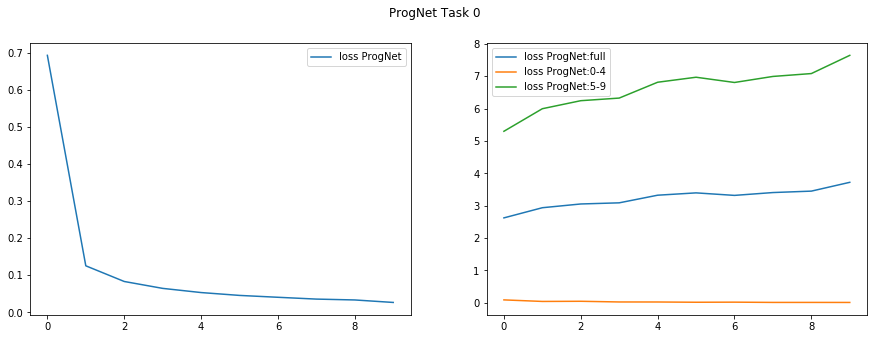

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

fig.suptitle('ProgNet Task 0')

ax1.plot(list(range(0,len(train_loss_pn))), train_loss_pn, label='loss ProgNet')
ax2.plot(list(range(0,len(test_loss_pn_full))), test_loss_pn_full, label='loss ProgNet:full')
ax2.plot(list(range(0,len(test_loss_pn_0))), test_loss_pn_0, label='loss ProgNet:0-4')
ax2.plot(list(range(0,len(test_loss_pn_1))), test_loss_pn_1, label='loss ProgNet:5-9')

ax1.legend()
ax2.legend()
plt.show()

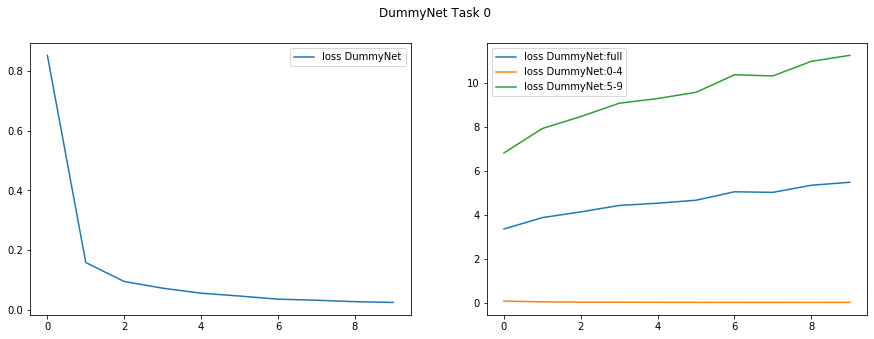

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

fig.suptitle('DummyNet Task 0')

ax1.plot(list(range(0,len(train_loss_d))), train_loss_d, label='loss DummyNet')
ax2.plot(list(range(0,len(test_loss_d_full))), test_loss_d_full, label='loss DummyNet:full')
ax2.plot(list(range(0,len(test_loss_d_0))), test_loss_d_0, label='loss DummyNet:0-4')
ax2.plot(list(range(0,len(test_loss_d_1))), test_loss_d_1, label='loss DummyNet:5-9')
ax1.legend()
ax2.legend()
plt.show()

### Training Phase 2
Column 1, digits 5 to 9

In [11]:
prog_net.freeze_columns()
prog_net.new_task(make_column_conv(activated = False),shapes)
prog_net = prog_net.to(device)

params = sum(p.numel() for p in prog_net.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(prog_net)

Total number of parameters is: 938692
ProgNet(
  (columns): ModuleList(
    (0): ModuleList(
      (0): LateralBlock(
        (block): Sequential(
          (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (u): ModuleList()
      )
      (1): LateralBlock(
        (block): Sequential(
          (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (u): ModuleList()
      )
      (2): LateralBlock(
        (block): Sequential(
          (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): BatchNorm2d(32, eps=1e-05, moment

In [12]:
#Training
learning_rate = 0.0001
num_epochs = 10

optimizer = optim.Adam(prog_net.parameters(),
                       lr = learning_rate)
optimizer_d = optim.Adam(dummy_net.parameters(),
                       lr = learning_rate)
criterion = F.cross_entropy

In [13]:
for epoch in tqdm(range(num_epochs)):
    #update prog_net
    train_loss_pn.append(train(model = prog_net,
                           dataloader = train_loader_1,
                           criterion = criterion, 
                           optimizer = optimizer, 
                           device = device))
    
    test_loss_pn_full.append(model_eval(model = prog_net,
                               dataloader = test_loader_full, 
                               criterion = criterion,
                               device = device))
    test_loss_pn_0.append(model_eval(model = prog_net,
                               dataloader = test_loader_0, 
                               criterion = criterion,
                               device = device,
                               task_id = 0))
    test_loss_pn_1.append(model_eval(model = prog_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device))
    #update dummy_net
    train_loss_d.append(train(model = dummy_net,
                           dataloader = train_loader_1,
                           criterion = criterion, 
                           optimizer = optimizer_d, 
                           device = device))
    
    test_loss_d_full.append(model_eval(model = dummy_net,
                               dataloader = test_loader_full, 
                               criterion = criterion,
                               device = device))
    test_loss_d_0.append(model_eval(model = dummy_net,
                               dataloader = test_loader_0, 
                               criterion = criterion,
                               device = device))
    test_loss_d_1.append(model_eval(model = dummy_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device))

100%|██████████| 10/10 [03:19<00:00, 19.94s/it]


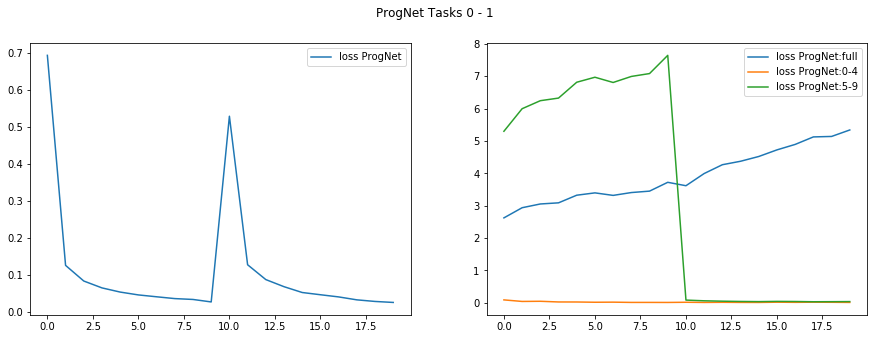

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

fig.suptitle('ProgNet Tasks 0 - 1')

ax1.plot(list(range(0,len(train_loss_pn))), train_loss_pn, label='loss ProgNet')
ax2.plot(list(range(0,len(test_loss_pn_full))), test_loss_pn_full, label='loss ProgNet:full')
ax2.plot(list(range(0,len(test_loss_pn_0))), test_loss_pn_0, label='loss ProgNet:0-4')
ax2.plot(list(range(0,len(test_loss_pn_1))), test_loss_pn_1, label='loss ProgNet:5-9')

ax1.legend()
ax2.legend()
plt.show()


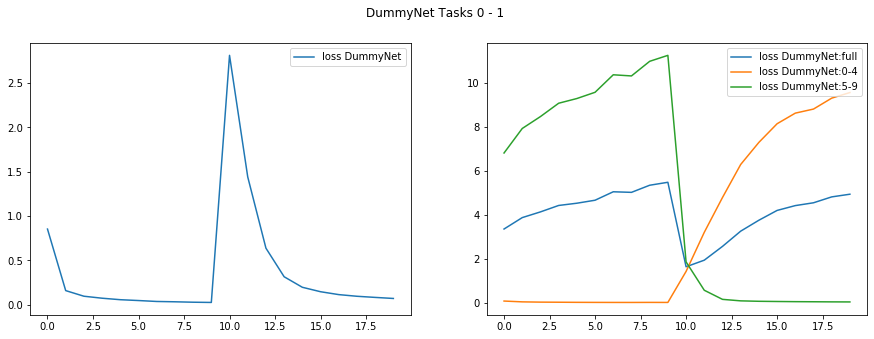

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

fig.suptitle('DummyNet Tasks 0 - 1')

ax1.plot(list(range(0,len(train_loss_d))), train_loss_d, label='loss DummyNet')
ax2.plot(list(range(0,len(test_loss_d_full))), test_loss_d_full, label='loss DummyNet:full')
ax2.plot(list(range(0,len(test_loss_d_0))), test_loss_d_0, label='loss DummyNet:0-4')
ax2.plot(list(range(0,len(test_loss_d_1))), test_loss_d_1, label='loss DummyNet:5-9')
ax1.legend()
ax2.legend()
plt.show()


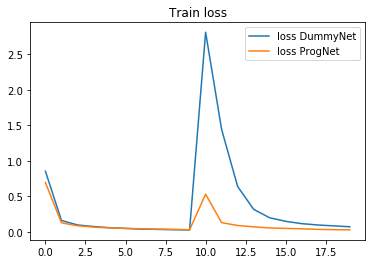

In [16]:

plt.plot(list(range(0,len(train_loss_d))), train_loss_d, label='loss DummyNet')
plt.plot(list(range(0,len(train_loss_pn))), train_loss_pn, label='loss ProgNet')
plt.title('Train loss')
plt.legend()
plt.show()

## Classification with ProgNet: random weights for column 0

In [17]:
prog_net_random = copy.deepcopy(prog_net).to(device)

for params in prog_net_random.columns[0].parameters():
    params.copy_(torch.rand_like(params))


In [18]:
test_pn = model_eval(model = prog_net,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device,
                               task_id = 1)
test_pnr = model_eval(model = prog_net_random,
                               dataloader = test_loader_1, 
                               criterion = criterion,
                               device = device,
                               task_id = 1)

print('(ProgNet) test loss:{:.4f}, (ProgNet + random col 0) test loss:{:.4f}'.format(test_pn,test_pnr))

(ProgNet) test loss:0.0380, (ProgNet + random col 0) test loss:44453685.6000
